<a href="https://colab.research.google.com/github/YanaKhlusova/ML_course/blob/main/Khlusova_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kagglehub

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# данные nltk для токенизации, лемматизации, удаления стоп-слов
# лемматизация в nltk базируется на POS-теггиинге и WordNet, поэтому данные для них тоже понадобятся
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# инициализация лемматайзера
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# скачаем датасет с твитами о запуске Chat GPT с kaggle
path = kagglehub.dataset_download("ryosyo0/chatgpt-tweets-sentiment-analysis-clean-data")

df = pd.read_csv(path + '/chatgpt_sentiment.csv')

# сколько всего строк в датасете?
df

100%|██████████| 160M/160M [00:02<00:00, 56.7MB/s]

Extracting files...


,Text,negative,neutral,positive,predicted_label,date,likes,location,followers,following,retweets,replies
0,If I were a journalist or reporter writing cli...,0.947877,0.040978,0.011144,negative,2023-02-10 23:59:49+00:00,1,Fukuoka 福岡 | Japan 日本,2012,388,0,0
1,Imagine if the mid season twist was that theyr...,0.031874,0.156266,0.811859,positive,2023-02-10 23:59:35+00:00,8,"Manhattan, NY",19855,5722,1,2
2,I see the difference between leader and employ...,0.158342,0.312784,0.528873,positive,2023-02-10 23:59:18+00:00,4,NaN,23,577,0,1
3,Which means your job is at risk Bill Gates say...,0.023860,0.931395,0.044745,neutral,2023-02-10 23:59:16+00:00,0,NaN,108,224,0,0
4,What have you been using Chatgpt for?,0.005627,0.968457,0.025916,neutral,2023-02-10 23:59:16+00:00,1,"Chicago, IL",11155,478,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
975445,"Just launched ChatGPT, our new AI system which...",0.004002,0.014325,0.981673,positive,2022-11-30 18:06:29+00:00,2370,NaN,203790,66,371,84
975446,"THRILLED to share that ChatGPT, our new model ...",0.005804,0.015195,0.979001,positive,2022-11-30 18:05:58+00:00,559,neighborhoodsf.com (sf),1572,604,67,26
975447,ChatGPT: Optimizing Language Models for Dialog...,0.003652,0.901520,0.094828,neutral,2022-11-30 18:02:58+00:00,2,The Internet,475,13,1,0
975448,"Try talking with ChatGPT, our new AI system wh...",0.003811,0.017800,0.978389,positive,2022-11-30 18:02:06+00:00,13597,NaN,1492374,0,3504,1313


In [3]:
# сразу дропаем те ряды, где пропущены тексты твитов
df = df.dropna(subset=['Text']).reset_index(drop=True)

In [56]:
# смотрим на распределение меток
df['predicted_label'].value_counts()

,count
predicted_label,
neutral,442168
positive,323976
negative,208883


In [4]:
# очень много строк, поэтому сэмплируем
# возьму примерно 30к строк, сэмплирование произведу так, чтобы сохранить распределение классов
df = df.groupby('predicted_label', group_keys=False).apply(
    lambda x: x.sample(frac=0.031, random_state=42)
).reset_index(drop=True)

/tmp/ipython-input-4-3163971335.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('predicted_label', group_keys=False).apply(


In [58]:
df

,Text,negative,neutral,positive,predicted_label,date,likes,location,followers,following,retweets,replies
0,ChatGPT is excellent. It exceeded all expectat...,0.483196,0.279364,0.237440,negative,2022-12-22 18:14:07+00:00,0,"Icaraí, Niterói",98,1073,0,0
1,"I tried it, also tried to make ChatGPT explain...",0.729446,0.245938,0.024616,negative,2023-02-02 09:44:40+00:00,0,"Cochabamba, Bolivia",441,555,0,0
2,ChatGPT PRO is announced at the same people c...,0.967241,0.021922,0.010837,negative,2023-02-03 00:09:33+00:00,3,"Atlanta, GA",563,219,0,0
3,"ChatGPT, created by San Francisco company Open...",0.980588,0.012243,0.007169,negative,2023-02-07 00:48:40+00:00,1,Philippines,15470,65,1,0
4,ChatGPT is predicting an untimely death for Jo...,0.911307,0.077578,0.011116,negative,2023-02-06 23:29:46+00:00,3,"Toronto, Ontario",3432,814,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
30220,"Fascinating. Like, at a loss for words over ho...",0.007902,0.009056,0.983041,positive,2023-01-16 00:16:37+00:00,0,Minting Now 👉👉👉,5567,3930,0,0
30221,"Trained on a massive dataset, its knowledge is...",0.031307,0.258329,0.710364,positive,2023-01-29 01:38:54+00:00,0,"Dallas, TX",1018,321,0,1
30222,I guess this makes sense and why ChatGPT is ar...,0.013337,0.090579,0.896084,positive,2023-02-04 04:49:36+00:00,20,NaN,73008,1013,3,1
30223,Generative AI has undeniably positive disrupti...,0.010832,0.037274,0.951893,positive,2022-12-29 04:47:16+00:00,4,"New Delhi, India",1328,2161,0,0


In [59]:
df['predicted_label'].value_counts()
# похоже на оригинальное распределение

,count
predicted_label,
neutral,13707
positive,10043
negative,6475


In [5]:
# чистка текстов: лемматизация, удаление стоп-слов
# для уменьшения размерности данных
# POS tag mapping for lemmatization
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text) # оставляем только слова на латинице
    text = re.sub(r'chat gpt', 'chatgpt', text) # chatgpt записан разными вариантами, нормализуем + делаем так, чтобы эти два слова рассматривались как одно
    text = re.sub(r'\s+', ' ', text).strip() # убираем лишние пробелы

    words = text.split()

    stop_words = stopwords.words('english')
    filtered_words = [word for word in words if word not in stop_words]

    # POS tagging and lemmatization
    pos_tags = pos_tag(filtered_words)
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags
    ]

    return ' '.join(lemmatized_words)

In [6]:
df["cleaned_text"] = df["Text"].apply(preprocessing)

df.head() # самый столбец - вычищенные тексты

,Text,negative,neutral,positive,predicted_label,date,likes,location,followers,following,retweets,replies,cleaned_text
0,ChatGPT is excellent. It exceeded all expectat...,0.483196,0.279364,0.237440,negative,2022-12-22 18:14:07+00:00,0,"Icaraí, Niterói",98,1073,0,0,chatgpt excellent exceed expectation question ...
1,"I tried it, also tried to make ChatGPT explain...",0.729446,0.245938,0.024616,negative,2023-02-02 09:44:40+00:00,0,"Cochabamba, Bolivia",441,555,0,0,try also tried make chatgpt explain able final...
2,ChatGPT PRO is announced at the same people c...,0.967241,0.021922,0.010837,negative,2023-02-03 00:09:33+00:00,3,"Atlanta, GA",563,219,0,0,chatgpt pro announce people complain high mini...
3,"ChatGPT, created by San Francisco company Open...",0.980588,0.012243,0.007169,negative,2023-02-07 00:48:40+00:00,1,Philippines,15470,65,1,0,chatgpt create san francisco company openai ca...
4,ChatGPT is predicting an untimely death for Jo...,0.911307,0.077578,0.011116,negative,2023-02-06 23:29:46+00:00,3,"Toronto, Ontario",3432,814,0,2,chatgpt predict untimely death john tory year


In [7]:
# закодируем строковые метки сентимента в числа
label_encoder = LabelEncoder()

df['predicted_label'] = label_encoder.fit_transform(df['predicted_label'])

y = df['predicted_label']

In [8]:
# разбиваем на три выборки: train, val, test
X = df['cleaned_text']
y = df['predicted_label']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 18135
Validation size: 6045
Test size: 6045


In [9]:
# токенизация (приведение к последовательностям) и паддинг (усечение последовательностей)
vocab_size = 10000
max_length = 50
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

def tokenize_and_pad(texts, tokenizer, max_length):
    seqs = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(seqs, maxlen=max_length, padding='post', truncating='post')
    return padded

X_train_padded = tokenize_and_pad(X_train, tokenizer, max_length)
X_val_padded = tokenize_and_pad(X_val, tokenizer, max_length)
X_test_padded = tokenize_and_pad(X_test, tokenizer, max_length)

In [68]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # т.к. 3 лейбла, мультиклассовая классификация
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [69]:
history = model.fit(
    X_train_padded,
    y_train,
    validation_data=(X_val_padded, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.5154 - loss: 0.9943 - val_accuracy: 0.6749 - val_loss: 0.7596
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7501 - loss: 0.6377 - val_accuracy: 0.6736 - val_loss: 0.7629
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8579 - loss: 0.4085 - val_accuracy: 0.6657 - val_loss: 0.8632
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9316 - loss: 0.2230 - val_accuracy: 0.6481 - val_loss: 1.0768
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.9665 - loss: 0.1204 - val_accuracy: 0.6420 - val_loss: 1.3372
Epoch 6/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9787 - loss: 0.0774 - val_accuracy: 0.6514 - val_loss: 1.6619
Epoch 7/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9851 - loss: 0.0513 - val_accuracy: 0.6369 - val_loss: 1.6845
Epoch 8/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9860 - loss: 0.0498 - 

Лоссы на обучении падают, а на валидации -- возрастают. Модель переобучилась.

In [70]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
# ну такое, хотя не так плохо, как могло бы быть

189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6293 - loss: 2.4308
Test Accuracy: 0.6374


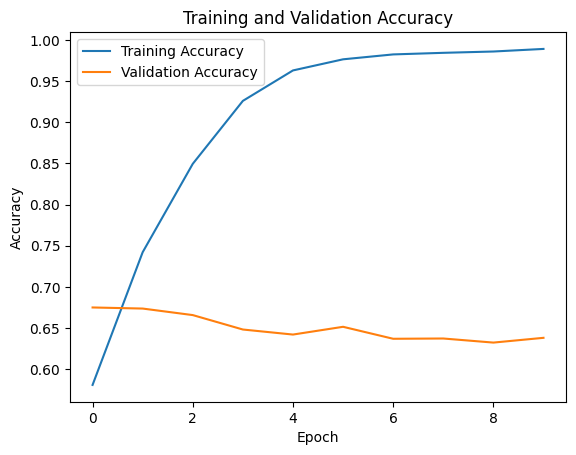

In [71]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [72]:
# Get predicted class indices
y_test_pred_prob = model.predict(X_test_padded)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


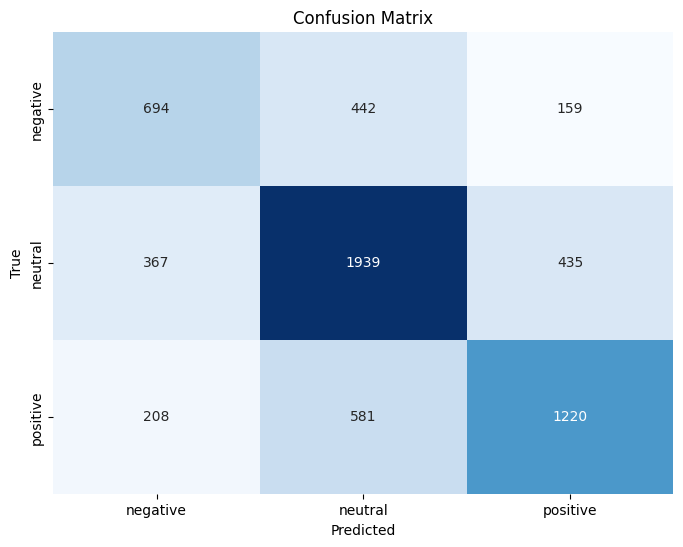

In [74]:
# возвращаем лейблы к строкам
y_true = y_test

# считаем матрицу ошибок
cm = confusion_matrix(y_true, y_test_pred)

# рисуем
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(label_encoder.classes_)) + 0.5, labels=label_encoder.classes_)
plt.yticks(ticks=np.arange(len(label_encoder.classes_)) + 0.5, labels=label_encoder.classes_)
plt.show()

In [75]:
# посмотрим также репорт
print("Classification Report:")
print(classification_report(y_true, y_test_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

    negative       0.55      0.54      0.54      1295
     neutral       0.65      0.71      0.68      2741
    positive       0.67      0.61      0.64      2009

    accuracy                           0.64      6045
   macro avg       0.62      0.62      0.62      6045
weighted avg       0.64      0.64      0.64      6045



Легче всего модели было предсказывать нейтральный класс, и это неудивительно:

- это доминирующий класс (что, кстати, может само по себе уменьшать качество работы модели),
- для этого не нужно искать определенные особенности в тексте.

Пробуем потюнить параметры модели:

*Здесь я снова использую model, потому что удаляла перемнные и окружение перед этим. Дальше буду переназывать модели, чтобы они не наслаивались.*

In [11]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=64, kernel_size=3, activation='relu',
           kernel_regularizer=l2(0.001)), # изменила на триграммы
    # твиты сравнительно коротки по длине, поэтому длинных последовательностей там быть не должно
    # также уменьшила кол-во фильтров
    BatchNormalization(), # нормализация между слоями
    GlobalMaxPooling1D(),
    Dense(32, activation='relu',
          kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adamw', # улучшенный адам
    metrics=['accuracy']
)

In [12]:
# останавливаем обучение, если на валидации прекращается улучшение
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2)
]

history = model.fit(
    X_train_padded,
    y_train,
    validation_data=(X_val_padded, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.4643 - loss: 1.3246 - val_accuracy: 0.6301 - val_loss: 1.0436 - learning_rate: 0.0010
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.7121 - loss: 0.8363 - val_accuracy: 0.6462 - val_loss: 0.9133 - learning_rate: 0.0010
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8279 - loss: 0.5596 - val_accuracy: 0.6415 - val_loss: 0.9810 - learning_rate: 0.0010
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8994 - loss: 0.3742 - val_accuracy: 0.6380 - val_loss: 1.1197 - learning_rate: 0.0010
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9461 - loss: 0.2486 - val_accuracy: 0.6374 - val_loss: 1.3520 - learning_rate: 2.0000e-04


In [13]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
# м-да

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6446 - loss: 0.9226
Test Accuracy: 0.6495


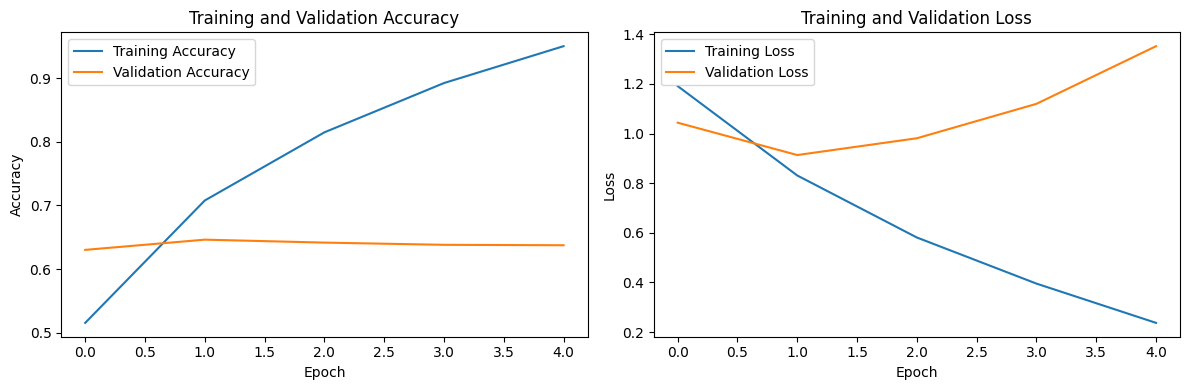

In [15]:
# Отрисовка графика прогресса обучения
plt.figure(figsize=(12, 4))

# Отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
# м-да х2
# но экьюраси на вале стала стабильнее

In [16]:
# Get predicted class indices
y_test_pred_prob = model.predict(X_test_padded)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


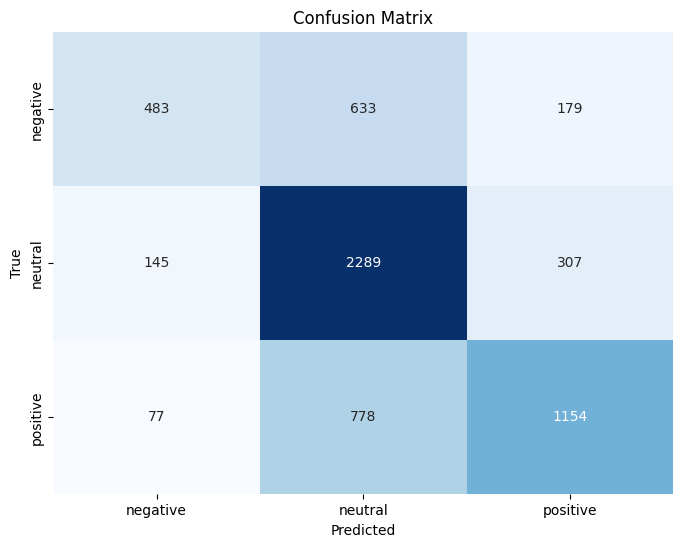

In [17]:
# возвращаем лейблы к строкам
y_true = y_test

# считаем матрицу ошибок
cm = confusion_matrix(y_true, y_test_pred)

# рисуем
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(label_encoder.classes_)) + 0.5, labels=label_encoder.classes_)
plt.yticks(ticks=np.arange(len(label_encoder.classes_)) + 0.5, labels=label_encoder.classes_)
plt.show()

In [18]:
# посмотрим также репорт
print("Classification Report:")
print(classification_report(y_true, y_test_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.37      0.48      1295
     neutral       0.62      0.84      0.71      2741
    positive       0.70      0.57      0.63      2009

    accuracy                           0.65      6045
   macro avg       0.67      0.59      0.61      6045
weighted avg       0.66      0.65      0.64      6045



Точность предсказания негативных текстов упала, зато нейтральные стали лучше предсказываться. Попробую еще вернуть фильтры.

In [23]:
model_1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=128, kernel_size=3, activation='relu',
           kernel_regularizer=l2(0.001)), # изменила на триграммы
    # твиты сравнительно коротки по длине, поэтому длинных последовательностей там быть не должно
    # также уменьшила кол-во фильтров
    BatchNormalization(), # нормализация между слоями
    GlobalMaxPooling1D(),
    Dense(64, activation='relu',
          kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adamw', # улучшенный адам
    metrics=['accuracy']
)

In [24]:
# останавливаем обучение, если на валидации прекращается улучшение
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2)
]

history = model_1.fit(
    X_train_padded,
    y_train,
    validation_data=(X_val_padded, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.4788 - loss: 1.4683 - val_accuracy: 0.6404 - val_loss: 1.1020 - learning_rate: 0.0010
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.7200 - loss: 0.8733 - val_accuracy: 0.6639 - val_loss: 0.9146 - learning_rate: 0.0010
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.8408 - loss: 0.5601 - val_accuracy: 0.6376 - val_loss: 0.9729 - learning_rate: 0.0010
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.9165 - loss: 0.3689 - val_accuracy: 0.6471 - val_loss: 1.1305 - learning_rate: 0.0010
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.9591 - loss: 0.2423 - val_accuracy: 0.6493 - val_loss: 1.3262 - learning_rate: 2.0000e-04


In [25]:
loss, accuracy = model_1.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
# м-да х3

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6513 - loss: 0.9274
Test Accuracy: 0.6557


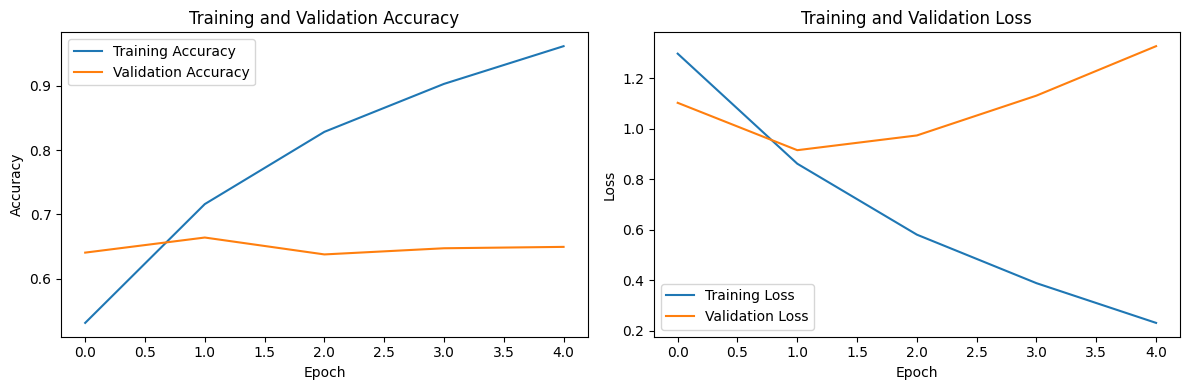

In [26]:
# Отрисовка графика прогресса обучения
plt.figure(figsize=(12, 4))

# Отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
# м-да х4
# ничего вообще не поменялось

In [35]:
# Get predicted class indices
y_test_pred_prob = model_1.predict(X_test_padded)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [36]:
# посмотрим также репорт
print("Classification Report:")
print(classification_report(y_true, y_test_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

    negative       0.53      0.60      0.56      1295
     neutral       0.69      0.70      0.69      2741
    positive       0.70      0.64      0.67      2009

    accuracy                           0.66      6045
   macro avg       0.64      0.64      0.64      6045
weighted avg       0.66      0.66      0.66      6045



Хоть и экьюраси не такая хорошая, качество предсказания негативных и позитивных текстов повысилось. F1 для нейтральныз уменьшилась на 0.02, но обычно важнее распознавать эмоционально окрашенные тексты.

Попробую добавить еще один слой свертки.

In [27]:
model_2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=128, kernel_size=3, activation='relu',
           kernel_regularizer=l2(0.001)), # изменила на триграммы
    # твиты сравнительно коротки по длине, поэтому длинных последовательностей там быть не должно
    # также уменьшила кол-во фильтров
    BatchNormalization(), # нормализация между слоями
    Conv1D(filters=128, kernel_size=3, activation='relu',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(), # нормализация между слоями
    GlobalMaxPooling1D(),
    Dense(64, activation='relu',
          kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adamw', # улучшенный адам
    metrics=['accuracy']
)

In [28]:
# останавливаем обучение, если на валидации прекращается улучшение
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2)
]

history = model_2.fit(
    X_train_padded,
    y_train,
    validation_data=(X_val_padded, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4339 - loss: 1.9899 - val_accuracy: 0.5199 - val_loss: 1.4462 - learning_rate: 0.0010
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.5635 - loss: 1.3214 - val_accuracy: 0.6177 - val_loss: 1.1551 - learning_rate: 0.0010
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.6905 - loss: 1.0064 - val_accuracy: 0.6319 - val_loss: 1.0739 - learning_rate: 0.0010
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7897 - loss: 0.7580 - val_accuracy: 0.6448 - val_loss: 1.0552 - learning_rate: 0.0010
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8524 - loss: 0.6018 - val_accuracy: 0.6321 - val_loss: 1.1749 - learning_rate: 0.0010
Epoch 6/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.8889 - loss: 0.4912 - val_accuracy: 0.6324 - val_loss: 1.1776 - learning_rate: 0.0010
Epoch 7/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.9402 - l

In [29]:
loss, accuracy = model_2.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
# м-да х5

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6432 - loss: 1.0672
Test Accuracy: 0.6470


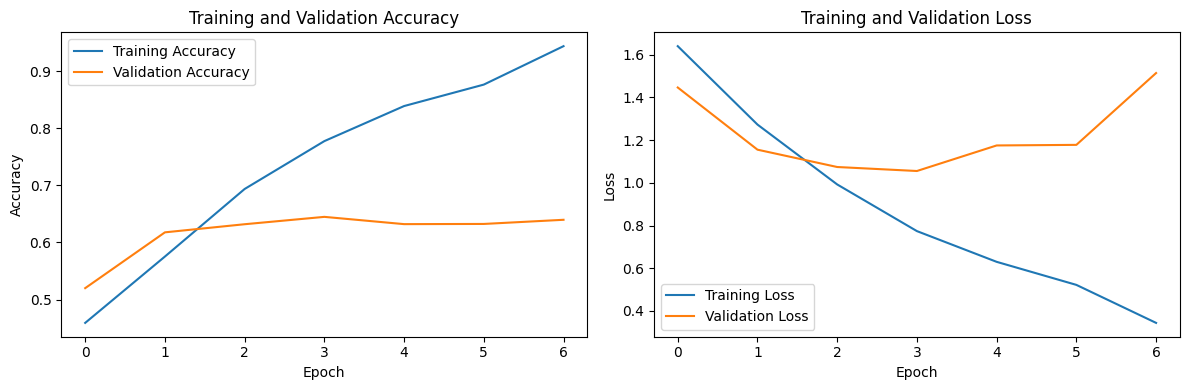

In [30]:
# Отрисовка графика прогресса обучения
plt.figure(figsize=(12, 4))

# Отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Get predicted class indices
y_test_pred_prob = model_2.predict(X_test_padded)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


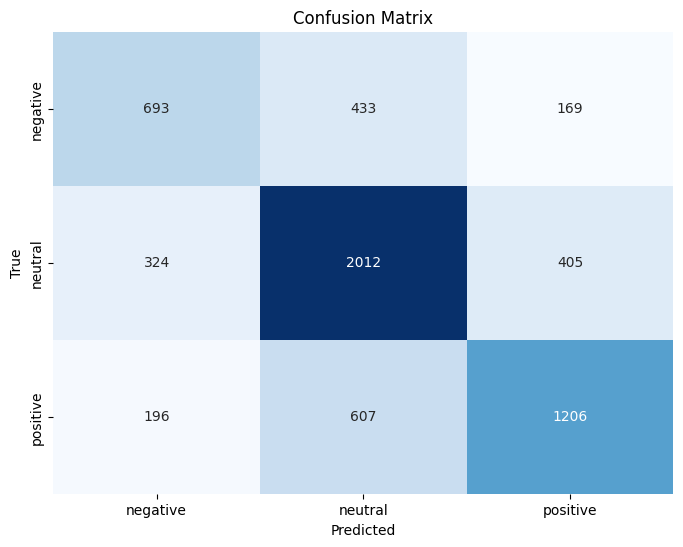

In [33]:
# возвращаем лейблы к строкам
y_true = y_test

# считаем матрицу ошибок
cm = confusion_matrix(y_true, y_test_pred)

# рисуем
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(label_encoder.classes_)) + 0.5, labels=label_encoder.classes_)
plt.yticks(ticks=np.arange(len(label_encoder.classes_)) + 0.5, labels=label_encoder.classes_)
plt.show()

In [34]:
# посмотрим также репорт
print("Classification Report:")
print(classification_report(y_true, y_test_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.54      0.55      1295
     neutral       0.66      0.73      0.69      2741
    positive       0.68      0.60      0.64      2009

    accuracy                           0.65      6045
   macro avg       0.64      0.62      0.63      6045
weighted avg       0.65      0.65      0.64      6045



Обучение прошло менее стабильно, а качество предсказания негативных и позитивных текстов повысилось. Оставляю модель без дополнительного сверточного слоя.

In [38]:
# сохраняем модель
model.save("tweets_cnn_model.keras")

In [39]:
# сохраняем лейбл энкодер для нее
import joblib

joblib.dump(label_encoder, "label_encoder.joblib")

['label_encoder.joblib']

## Что дальше:

Экьюраси все еще не такая прекрасная (0.65), поэтому можно дальше тюнить гиперпараметры. Также можно увеличить кол-во строк в датасете (напр., 50 или даже 100К).

Кроме того, проблема может быть и в самих данных. Нужен лингвистический анализ того, насколько хорошо присвоены метки текстам (это было сделано автоматически с помощью нафайнтюненной модели). Еще, как я уже упоминала выше, на экьюраси может отрицательно влиять дисбаланс по классам, можно попробовать устранить его (снизить кол-во нейтральных текстов или вообще убрать их, поскольку при анализе тех же отзывов нейтраль не дает никакой информации).